# Problem Statement

Part 1: Preprocessing with Bag-of-Words

The original dataset contains 5,261,668 reviews and we select 2000 from them, where half of them for reviews with 1 and 5 stars respectively.
Download and import the dataset. And then extract text and stars columns as your X (data) and y (label). You may find pandas or numpy package helpful (if you are using Python). Both have functions to load CVS files.
Convert the text into lower case then into bag-of-words representation. You can use a library such as one found in sklearn (if you are using Python). Do not use a pre-existing list of stop-words.
Bag-of-words Analysis and Repreprocessing.
Graph the distribution of words counts vs word rank.

Identify the set of common stop words by looking at the words. What stop words did you choose?
Choose a max document frequency theshold for word occurances and a minimum word occurance to cull the less useful words.
Reprocess your data using the stop-words list you determined, the max document frequency and the minimum word occurance.
Graph the updated words counts vs word rank.
After removing stop-words, convert all the data into bag-of-words vectors for use in the next part.

Part 2: Text-Retrieval

In this section, we look at finding similar documents to a query phrase.

Using nearest neighbor with a cos-distance metric, find 5 reviews matching Horrible customer service.
Print the original text from the review along with the associated distance score. You can truncate the review to 200 words so we don't get a page of text.
Looking at all the distance scores, how many documents do you think are good matches to the query?

Part 3: Classification with Logistic Regression

Here, we attempt to classify good reviews vs bad reviews using Logistic Regression.
Separate your data in train and test sets. Use 10% of the data for test.
Create a classifier based on Logistic Regression. Feel free to use whatever packages you like. In Python, sklearn should have what you need.
What is the accuracy on the training set and the test set of your classifier?
Logistic Regession returns a probability of the positive label. Although it is common to use 0.5 as the threshold to call something positive or negative, depend on your use case and the data, sometimes a different threshold is better.
Plot a histogram of the scores on the training data.
Example (make yours bigger):  
Choose a new threshold based on your plot and report the accuracy on the training set and the test set. Did it improve?
An ROC curve shows the trade-off of correct positive predictions (true positives) vs incorrect positive predictions (false positives) as the classification threshold is adjusted. Plot the ROC curve for your classifier.
Example (make yours larger): 
At what false positive rate would your classifier minimize false positives while maximizing true positives?

In [49]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from sklearn.metrics.pairwise import cosine_similarity as cosdis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [50]:
#Perform data cleaning on the dataset
def perform_data_cleaning(yelp):
    yelp["text"] = yelp["text"].str.lower()
    yelp['text'] = yelp['text'].str.replace(r'[^\w\s]+', '')
    yelp['text'] = [re.sub('[%s]' % re.escape(string.punctuation),'',line) for line in yelp['text']] #remove punctuations
    yelp['text']  = [re.sub('\n','',line) for line in yelp['text'] ] #removing '/n'
    yelp['text']  = [re.sub('\w*\d\w*','',line) for line in yelp['text'] ]  #removing digits
    return yelp

#Calculate frequency of each word in the dataset  
def calc_words_freq(dataset):    
    vec = CountVectorizer().fit(dataset)
    bag_of_words = vec.transform(dataset)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [list((word, sum_words[0, idx])) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq
    
#Display word frequency plot (word count vs word rank)
def disp_words_freq(words_freq):    
    words, counts = (zip(*words_freq))
    plt.plot([x + 1 for x in range(len(counts))], counts)
    plt.xlabel('Word rank')
    plt.ylabel('Word count')
    plt.title('Word Frequency')
    plt.show()
    
#Tokenize each word of the dataset    
def tokenize_text(yelp):
    tokenized_text = []
    tokenizer = TweetTokenizer()
    for lines in yelp['text']:
        tokenized_text.append(tokenizer.tokenize(lines))
    return tokenized_text

#Calculate document frequency of each word    
def create_word_stat(words_freq, tokenized_text):
    word_stats = []
    for word,count in words_freq:
        word_doc_count=0
        for lines in tokenized_text:
            for token in lines:
                if word == token:
                    word_doc_count += 1
                    break
        doc_freq = float (word_doc_count/len(tokenized_text))
        word_stats.append([word, count, doc_freq])
    return word_stats

#Create a list of less useful words having word occurance > 800 or document frquency > 0.7 (or 70%)
def create_word_list(word_stats):    
    less_useful_words = []
    for word, count, doc_freq in word_stats:
        if count < 800 and doc_freq < 0.7 :
            continue
        less_useful_words.append(word)
    return less_useful_words

#Remove list of stop words from the dataset
def remove_stop_words(dataset, stop_words):
    output = dataset.str.split(' ').apply(lambda x: ' '.join(k for k in x if k not in stop_words))
    return output


In [51]:
yelp = pd.read_csv("yelp_2k.csv")
yelp = yelp[["text","stars"]]
yelp = perform_data_cleaning(yelp)

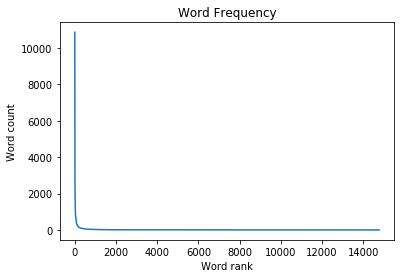

14773


In [52]:
#Part-1
words_freq = calc_words_freq(yelp["text"])
disp_words_freq(words_freq)
print(len(words_freq))

In [53]:
stop_words = ['the', 'and', 'to', 'was', 'of', 'it', 'for', 'their', 'in',
             'is', 'my', 'that', 'they', 'them', 'this', 'we', 'with', 'you',
             'on', 'will', 'about', 'have', 'had', 'me', 'at', 'so', 'here',
             'were', 'are', 'be', 'as', 'an', 'if', 'he', 'she', 'there',
             'all', 'when', 'out', 'our', 'your', 'us', 'been']

yelp['text'] = remove_stop_words(yelp['text'], stop_words)

In [54]:
words_freq = calc_words_freq(yelp["text"])
tokenized_text = tokenize_text(yelp)
#
word_stats = create_word_stat(words_freq, tokenized_text) 

less_useful_words = create_word_list(word_stats)  
yelp['text'] = remove_stop_words(yelp['text'], less_useful_words)

print(less_useful_words)
print('\n' , 'No. of stop words: ',len((less_useful_words)))

['not', 'but', 'place', 'food']

 No. of stop words:  4


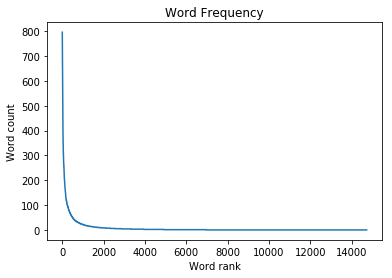

14726


In [55]:
words_freq = calc_words_freq(yelp["text"])
disp_words_freq(words_freq)
print(len(words_freq))

In [56]:
#Part-2
vec = CountVectorizer().fit(yelp["text"])
bag_of_words = vec.transform(yelp["text"])
target = vec.transform(["horrible customer service"])
neighbour = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine')
neighbour.fit(bag_of_words)
k = 5
dist, index = neighbour.kneighbors(target.toarray(), n_neighbors=k)
index = index.flatten()
dist = dist.flatten()
for i in range(k):
    print("distance: ", dist[i])
    print(yelp.iloc[index[i]]["text"])
    print("------------------------------------------")

distance:  0.48673509742526344
horrible service horrible customer service horrible quality service  do waste time or money using company pool needs  dan  broke pool filtration system left a nonworking condition  repair issue caused told go somewhere else  save yourself hassle plenty other quality pool companies  take care
------------------------------------------
distance:  0.5370899501137242
rogers  over  horrible customer  faulty incorrect  poor customer  enough  never arrive appointment
------------------------------------------
distance:  0.5470891863421616
service horrible came a major attitude payed  lasagna no where worth wont ever going back never recommend treated absolutely horrible horrible
------------------------------------------
distance:  0.6107505279192385
went marca today get a haircut given a great service both by front desk  customer service by georgia girl who did hair i guess i got lucky her has years experience doing job has excellent customer service skills tak

In [77]:
#distance metric for all documents
k = len(yelp["text"])
dist, index = neighbour.kneighbors(target.toarray(), n_neighbors=k)
index = index.flatten()
dist = dist.flatten()
df = pd.concat([pd.Series(index), pd.Series(dist)], axis=1)
df.columns = ['index', 'distance']
df = df.sort_values(by = 'distance')
df.head(10)

,index,distance
0,90,0.486735
1,1808,0.537090
2,729,0.547089
3,1721,0.610751
4,9,0.615100
5,825,0.615100
6,603,0.630726
7,1723,0.630726
8,980,0.643652
9,1429,0.651845


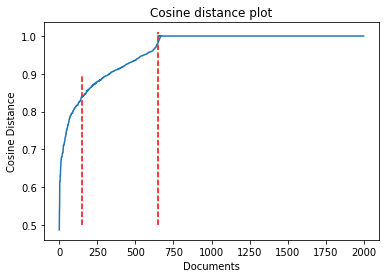

In [93]:
x= df.sort_values(by = 'distance')
plt.vlines(x = 150, ymin = 0.5, ymax = 0.9, color = 'r', linestyles = 'dashed')
plt.vlines(x = 650, ymin = 0.5, ymax = 1.01, color = 'r', linestyles = 'dashed')
plt.xlabel('Documents')
plt.ylabel('Cosine Distance')
plt.title('Cosine distance plot')
plt.plot(x.index, dist)
plt.show()

In [60]:
# Part- 3: Logistic regression

In [61]:
#Separate data in train and test sets. Use 10% of the data for test.
X = bag_of_words.toarray()
y = yelp['stars'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [62]:
# Create LR classifier
# Print accuracy on the training set and the test set of the classifier

LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train,y_train)

y_pred_train = LR.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)
print(f'Train Set Accuracy Score: {round(accuracy *100, 2)} %')

y_pred_test = LR.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Test Set Accuracy Score: {round(accuracy *100, 2)} %')

Train Set Accuracy Score: 99.94 %
Test Set Accuracy Score: 93.5 %


In [63]:
prob_train = LR.predict_proba(X_train)

In [64]:
prob_train

array([[0.00276895, 0.99723105],
       [0.07144667, 0.92855333],
       [0.99346101, 0.00653899],
       ...,
       [0.92676999, 0.07323001],
       [0.0018285 , 0.9981715 ],
       [0.9972955 , 0.0027045 ]])

Minimum probability of positive class:  0.6387161632185241


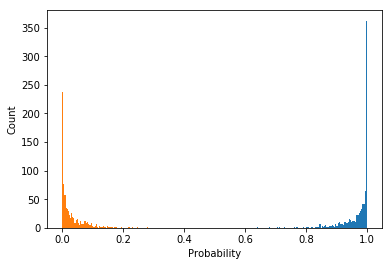

In [65]:
pos_prob = [x[0] for x in prob_train[y_pred_train == 1]]
neg_prob = [x[0] for x in prob_train[y_pred_train == 5]]
print('Minimum probability of positive class: ', np.min(pos_prob))
plt.hist(pos_prob, bins=100)
plt.hist(neg_prob, bins=100)
plt.xlabel('Probability')
plt.ylabel('Count')
#plt.savefig('probability_histogram.png')
#plt.clf()
plt.show()

In [66]:
# Choosing a new threshold based on the plot and checking the accuracy on the training set and the test set.
# since the minimum probability of positive class is 0.6387, so threshold = 0.63
threshold = 0.63
prob_train = LR.predict_proba(X_train)
y_pred_train_new = [1 if x[0] > threshold else 5 for x in prob_train]
accuracy = accuracy_score(y_train, y_pred_train_new)
print(f'Train Set Accuracy Score: {round(accuracy *100, 2)} %')

prob_test = LR.predict_proba(X_test)
y_pred_test_new = [1 if x[0] > threshold else 5 for x in prob_test]
accuracy = accuracy_score(y_test, y_pred_test_new)
print(f'Test Set Accuracy Score: {round(accuracy *100, 2)} %')

Train Set Accuracy Score: 99.94 %
Test Set Accuracy Score: 94.0 %


The test accuracy has increased by 0.5% after putting the new threshold.

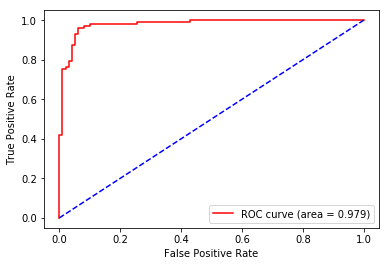

In [67]:
#ROC curve
#Plotting the ROC curve for the classifier
prob_test = LR.predict_proba(X_test)
y_true = [0 if y == 1 else 1 for y in y_test]
y_score = prob_test[:,1]
fpr, tpr, threshold = roc_curve(y_true, y_score)
area = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.3f)' % area)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], color='blue', linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('roc.png')
# plt.clf()
plt.show()

In [103]:
#Calculating the optimum threshold
# We will calculate the optimum threshold  by using the roc curve where 
# true positive rate(tpr) and 1 - false positive rate(fpr) overlap.
# The point of minimum distance between tpr and 1-fpr maximizes true positive while minimizing false negatives.

min_dist = 500
for fp,tp,thr in zip(fpr, tpr, threshold):
    dist = np.sqrt(np.square(1-tp) + np.square(fp))
    if dist < min_dist:
        best_combination = (fp, tp, thr)
        min_dist = dist
        
print('Optimum Threshold that minimizes false positives while maximizing true positives : ', best_combination[2], '\n')

print('Corresponding best combination of (FPR, TPR) is (',best_combination[0],', \
      ',best_combination[1],')')

Optimum Threshold that minimizes false positives while maximizing true positives :  0.444347617988936 

Corresponding best combination of (FPR, TPR) is ( 0.061224489795918366 ,        0.9607843137254902 )
